In [15]:
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import RepeatedKFold
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

import data_load
import data_process
import model
import train_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
DATA_PATH = "data/Turbine_Data_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"
LOGS_PATH = "data/Status_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"

data = data_load.load_turbine_data_without_time(DATA_PATH)
logs = data_load.load_turbine_logs_with_endtime(LOGS_PATH)
labels = data_load.get_data_label(data_load.load_turbine_data(DATA_PATH), logs)
data_imputer = KNNImputer(n_neighbors=10)
data = data_process.impute_data(data)
data = data_process.standardize_data(data)
data = np.array(data, dtype='float32')

In [17]:
epochs = 3000
k = 10
kf = RepeatedKFold(n_splits=k, n_repeats=1)
i = 0
labels = np.array(labels)

for train, test in kf.split(data):
    ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
    loss = nn.MSELoss()
    # optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
    optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)
    train_labels = labels[train]
    test_labels = labels[test]
    X_train, X_test = data[train][train_labels==0], data[test]
    for epoch in range(epochs):
        print(f"\n=====epoch {epoch}/{epochs}=====")
        train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
                          batch_size=30000)

    res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)
    i += 1
    if i == 1:
        break


=====epoch 0/3000=====
loss: 0.797779  [21871/21871]

=====epoch 1/3000=====
loss: 0.796440  [21871/21871]

=====epoch 2/3000=====
loss: 0.795039  [21871/21871]

=====epoch 3/3000=====
loss: 0.793298  [21871/21871]

=====epoch 4/3000=====
loss: 0.790965  [21871/21871]

=====epoch 5/3000=====
loss: 0.787743  [21871/21871]

=====epoch 6/3000=====
loss: 0.783230  [21871/21871]

=====epoch 7/3000=====
loss: 0.776914  [21871/21871]

=====epoch 8/3000=====
loss: 0.767880  [21871/21871]

=====epoch 9/3000=====
loss: 0.755342  [21871/21871]

=====epoch 10/3000=====
loss: 0.738066  [21871/21871]

=====epoch 11/3000=====
loss: 0.714482  [21871/21871]

=====epoch 12/3000=====
loss: 0.683268  [21871/21871]

=====epoch 13/3000=====
loss: 0.644109  [21871/21871]

=====epoch 14/3000=====
loss: 0.599333  [21871/21871]

=====epoch 15/3000=====
loss: 0.557777  [21871/21871]

=====epoch 16/3000=====
loss: 0.537509  [21871/21871]

=====epoch 17/3000=====
loss: 0.524971  [21871/21871]

=====epoch 18/3000=

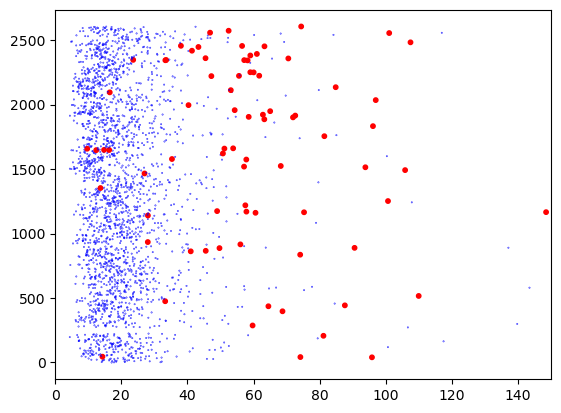

In [19]:

res_sorted = np.sort(res)
res_cdf = 1. * np.arange(len(res)) / (len(res) - 1)
point_color = ["red" if label == 1 else "blue" for label in test_labels]
point_size = [0.1 if label == 0 else 10 for label in test_labels]
# plt.hist(res, bins=200)
# plt.scatter(res_sorted, res_cdf, s=point_size, c=point_color)

plt.scatter(res, range(res.size), s=point_size, c=point_color)
plt.xlim(0, 150)
plt.show()

In [ ]:
test_labels